Installing the Necessary Libraries

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc


Loading the dataset

In [2]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Paths
train_dir = "dataset/train"
val_dir = "dataset/val"

# Load training dataset
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Load validation dataset
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.prefetch(buffer_size=AUTOTUNE)

# ✅ Correct way to access class names
print("Classes found:", train_ds_raw.class_names)


Found 275 files belonging to 2 classes.
Found 70 files belonging to 2 classes.
Classes found: ['cat', 'dog']


In [3]:
cat_directory_paths  = "D:\Euron\CV\class4\dataset\train\cat" 
dog_directory_paths  = "D:\Euron\CV\class4\dataset\train\dog"

Loadign the Image 

In [4]:
import  cv2
cat_image = cv2.imread(r"D:\Euron\CV\class4\dataset\train\cat\Bengal_13_jpg.rf.7c75131d257406a75d8d676dd9b5f5f7.jpg")
print(cat_image.shape)

(256, 500, 3)


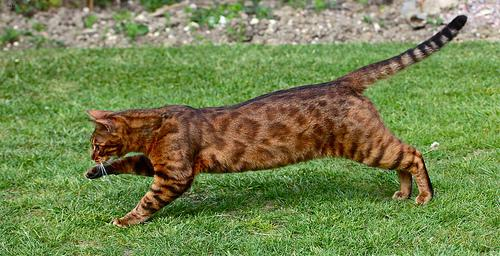

In [5]:
from PIL import Image
from IPython.display import display
img = Image.open(r"D:\Euron\CV\class4\dataset\train\cat\Bengal_13_jpg.rf.7c75131d257406a75d8d676dd9b5f5f7.jpg")
display(img)


Splitting the data usingn batches 

In [6]:
base_dir = r'D:\Euron\CV\class4\dataset\train'  

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [8]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'
)

Found 220 images belonging to 2 classes.


In [9]:
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 55 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

Building the Model

In [11]:
model = models.Sequential([
    # Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    # Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Layer 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()

c:\Users\Deepu\anaconda3\envs\cv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])  

In [13]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

c:\Users\Deepu\anaconda3\envs\cv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 883ms/step - accuracy: 0.6177 - loss: 0.8449 - val_accuracy: 0.6545 - val_loss: 0.6564
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - accuracy: 0.7058 - loss: 0.5959 - val_accuracy: 0.6545 - val_loss: 0.6602
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step - accuracy: 0.6683 - loss: 0.6421 - val_accuracy: 0.6545 - val_loss: 0.6271
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - accuracy: 0.6386 - loss: 0.6495 - val_accuracy: 0.6545 - val_loss: 0.6166
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.6622 - loss: 0.6061 - val_accuracy: 0.6545 - val_loss: 0.5977
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.6665 - loss: 0.5633 - val_accuracy: 0.6545 - val_loss: 0.5806
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.7082 - loss: 0.5360 - val_accuracy: 0.7636 - val_loss: 0.6115
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.7731 - loss: 0.5548 - val_accuracy: 0

In [14]:

print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")

if 'val_loss' in history.history:
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
if 'val_accuracy' in history.history:
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Final Training Loss: 0.4998
Final Training Accuracy: 0.7545
Final Validation Loss: 0.5786
Final Validation Accuracy: 0.6909


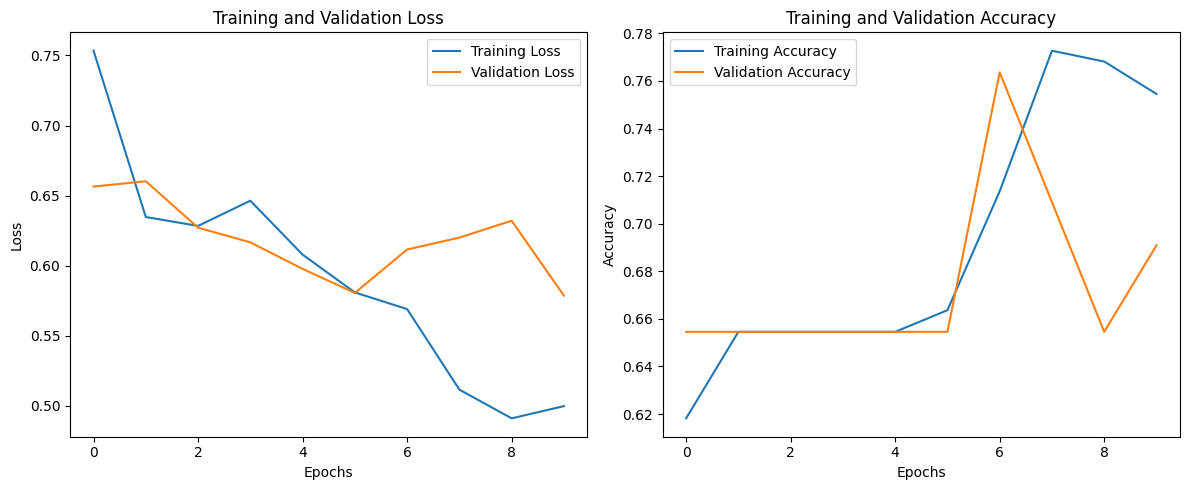

In [15]:
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Testing the model

In [16]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [17]:
test_dir = r"D:\Euron\CV\class4\dataset\val"
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)


Found 70 images belonging to 2 classes.


In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5512 - loss: 0.7409
Test Loss: 0.6263
Test Accuracy: 0.6571


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


<Axes: >

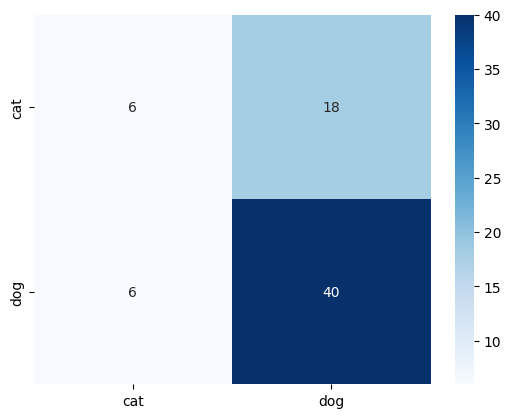

In [21]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)


In [22]:
print("Unique predicted classes:", np.unique(predicted_classes))
print("Class distribution:", np.bincount(predicted_classes.flatten()))




Unique predicted classes: [0 1]
Class distribution: [12 58]


In [23]:
print("Confusion Matrix Raw Values:")
print(cm)


Confusion Matrix Raw Values:
[[ 6 18]
 [ 6 40]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


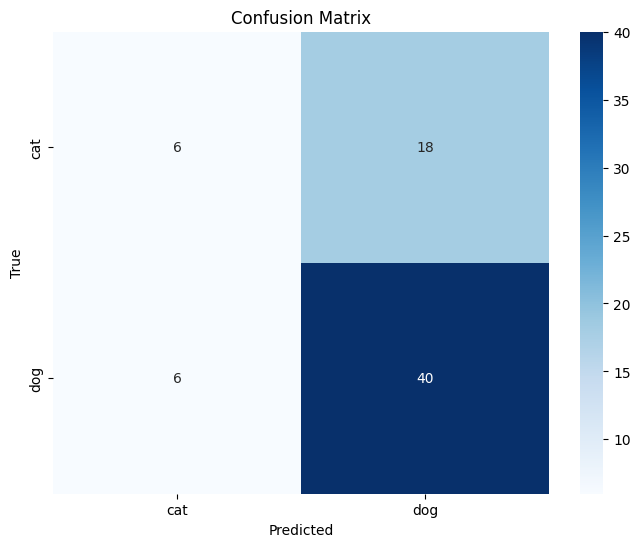

In [24]:
# Make predictions on the test set
predictions = model.predict(test_generator)
# Convert predictions to class labels
predicted_classes = (predictions > 0.5).astype("int32")
# Get true labels from the generator
true_classes = test_generator.classes
# Get class labels
class_labels = list(test_generator.class_indices.keys())
# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         cat       0.50      0.25      0.33        24
         dog       0.69      0.87      0.77        46

    accuracy                           0.66        70
   macro avg       0.59      0.56      0.55        70
weighted avg       0.62      0.66      0.62        70



In [26]:
roc_auc = roc_auc_score(true_classes, predictions)
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.7056


AUC: 0.7056


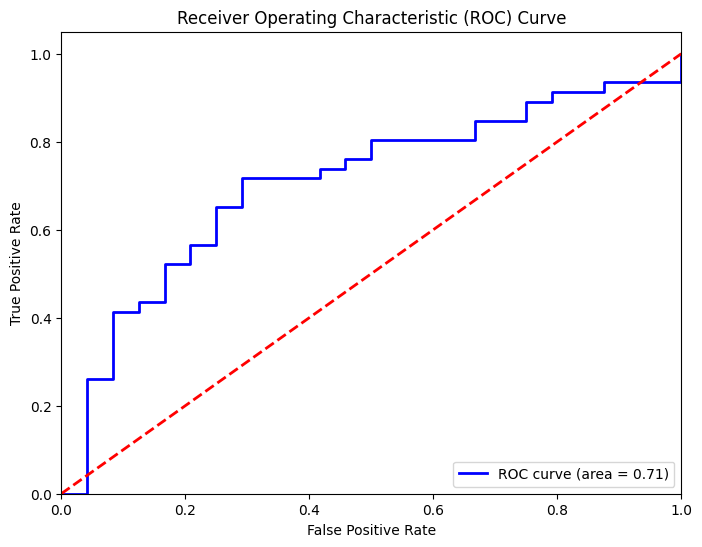

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [28]:
# Optional: suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Save the model in Keras format
model.save('cat_dog_classifier.keras')
print("✅ Model saved as cat_dog_classifier.keras")

# Save the model in HDF5 format
model.save('cat_dog_classifier.h5')
print("✅ Model also saved as cat_dog_classifier.h5")

# Reload and compile the model explicitly to avoid warnings
loaded_model = tf.keras.models.load_model('cat_dog_classifier.h5')
loaded_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("✅ Model reloaded and compiled.")

# Re-evaluate to confirm correct loading
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(test_generator)
print(f"Reloaded Model Test Loss: {loaded_test_loss:.4f}")
print(f"Reloaded Model Test Accuracy: {loaded_test_accuracy:.4f}")


✅ Model saved as cat_dog_classifier.keras
✅ Model also saved as cat_dog_classifier.h5
✅ Model reloaded and compiled.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5512 - loss: 0.7409
Reloaded Model Test Loss: 0.6263
Reloaded Model Test Accuracy: 0.6571
